# Kак роботы планируют траекторию движения

In [1]:
# Не изменяйте эту ячейку и запустите её перед началом работы!
!pip install pygame
from src.game_common.game import start_game as start_game_common
from src.game_advanced.game import start_game as start_game_advanced
from src.test.simple_test import draw_test_map
from src.test.simple_test import simple_test
from src.game_common.game import start_game as start_game_common
import math

zsh:1: command not found: pip
pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


![1](./Image/1.png)

В этом ноутбуке мы рассмотрим проблему нахождения кратчайшего пути на карте. Эта задача используется в робототехнике, компьютерных играх и сервисах такси, доставки и т.п. В данном ноутбуке карта будет представлять из себя сетку, в которой одни клетки проходимы, а другие представляют собой препятствия. Существуют разные спрособы определять соседей клетки, например, соседями могут являться только смежные клетки с данной или можно еще разрешать ходить по диагонали при некоторых ограничениях. В этом задании будем предполагать, что мы можем ходить только по смежным клеткам: вверх, вниз, влево и вправо.

Базовым алгоритмом поиска кратчайшего пути является алгоритм Дийкстры. Суть алгоритма проста — обходить вершины в порядке возрастания расстояния от начальной вершины. Для этого мы храним для каждой вершины метку `g` — минимальное известное расстояние от начальной вершины до этой (изначально для стартовой вершины оно равно `0`, а для всех остальных `infty`).
 На каждом шаге мы рассматриваем вершину с минимальным g среди нерассмотренных (Понятно, что на первой итерации выбрана будет стартовая вершина). Нетрудно доказать, что при неотрицательных весах при рассмотрении `g` этой вершины равно истинному значению минимального расстояния.  Далее, на текущей итерации, из рассматриваемой вершины производятся релаксации: мы пытаемся улучшить значение `g` для всех соседей этой вершины, то есть
 
`neighbour.g = min(neighbour.g, self.g + dist(self, neighbour))`

![2](./Image/dijkstra.gif)

В нашем случае мы решаем задачу поиска кратчайшего пути до одной конкретной вершины, значит во время рассмотрения этой самой вершины алгоритм можно и нужно остановить. Помимо этого в нашей ситуации много упрощений, поскольку граф клетчатый, соседи - это несколько смежных клеток, а веса рёбер равны единице.

Однако алгоритм Дийкстры имеет большой минус: если мы ищем кратчайший путь от начальной вершины до конкретной, то мы рассмотрим ВСЕ вершины, расстояние до которых меньше чем до целевой, даже если они в противоположной от неё стороне. Например, если мы хотим долететь из Новосибирска до Владивостока, то зачем лететь с пересадкой в Москве, ведь она находится в противоположной стороне. Чтобы это исправить, рассмотрим `h` — эвристическую функцию вершины. Это оценка расстояния от неё до конечной. И тогда логично брать вершину не с минимальным `g`, а минимальным значением `f = g + h`. Такой алогоритм называется A* (A-star, А-звёздочка). Вот наглядный пример его работы:

![3](./Image/astar.gif)

Как видите, алгоритм не рассматривает многие вершины, которые алгоритм Дийсткры бы рассмотрел. Таким образом, хорошая метрика для A* как раз поможет избежать лишних действий

Введём класс `Node`, описывающий вершину. У него есть следующие поля:
- `i`, `j` - координаты вершины;
- `g`;
- `f = g + h`;
- parent - вершина, из которой мы пришли в данную. По этому полю мы сможем восстановить путь.

In [2]:
class Node:
    def __init__(self, i, j, g = math.inf, h = 0, parent = None):
        self.i = i
        self.j = j
        self.g = g
        self.f = self.g + h       
        self.parent = parent
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j)
    
    def __gt__(self, other):
        return self.f > other.f
    
    def __hash__(self):
        return 31 + 7 * (hash(self.i) + 7 * hash(self.j))
    
    def __str__(self):
        return 'i: {0}, j: {1}, g: {2}, F: {3}, parent: {4}'.format(self.i, self.j, self.g, self.f, self.parent)

Теперь определим класс `Grid`, описывающий граф, в котором робот будет искать путь. У него есть следующие поля:
- `height`, `width` - высота и ширина, то есть размер поля по оси X и Y соответсвенно;
- `cells` - двумерная матрица, описывающая клетки поля. Если значение `cells[i][j]` равно `1`, то это значит, что через клетку в `i`-м ряду и `j`-й столбце можно пройти. Если же оно равно `0`, то клетка непроходима.

In [3]:
class Grid:

    def __init__(self, height=0, width=0, cells=[]):
        self.height = height
        self.width = width
        self.cells = cells

    # Проверка, не выходит ли клетка (i, j) за границы поля   
    def in_bounds(self, i, j):
        return (0 <= j < self.width) and (0 <= i < self.height)
    
    # Проверка, можно ли пройти через клетку (i, j) 
    def traversable(self, i, j):
        return not self.cells[i][j]
    
    # Список соседей клетки (i, j) в виде list-а из tuple-ов вида (n_i, n_j)
    def get_neighbors(self, i, j):
        neighbors = []
        
        # TODO! Реализуйте эту функцию!
        # Робот может ходить только прямо, то есть по диагонали ходить нельзя.
        # Не забывайте про границы и непроходимые клетки!

        return neighbors

### Реализация Open и Closed

В нашей реализации мы будем использовать два класса — `Open` и `Closed`. `Open` содержит нерассмотренные вершины, а `Closed` — уже рассмотренные. 

У `Open` есть следующие методы: 
 - `is_empty` - является ли множеством пустым
 - `add_node` - добавить вершину (или обновлять значение её `g`, если она уже была добавлена)
 - `get_best_node` - извлечь вершину с минимальным `f`.

In [4]:
class Open:
    def __init__(self):
        self.elements = []
    
    def __iter__(self):
        return iter(self.elements)

    def __len__(self):
        return len(self.elements)

    def is_empty(self):
        if len(self.elements) != 0:
            return False
        return True
    
    def add_node(self, item : Node):
        for coord in range(len(self.elements)):
            if self.elements[coord].i == item.i and self.elements[coord].j == item.j:
                if (self.elements[coord].g > item.g):
                    self.elements[coord].f = item.f
                    self.elements[coord].g = item.g
                    self.elements[coord].parent = item.parent
                    return
                else:
                    return
        self.elements.append(item)
        return

    def get_best_node(self):
        best_f = math.inf
        best_coord = 0
        for i in range(len(self.elements)):
            if (self.elements[i].f < best_f):
                best_coord = i
                best_f = self.elements[i].f
                
        best = self.elements.pop(best_coord)
        return best
    

Приечание: на самом деле, приведённая реализация `Open` ОЧЕНЬ неэффективная. Дело в том, что она хранит вершины в списке(list). На практике, если нам нужно быстро доставать элемент с минимальным значением, используется куча(heap).

У `Closed` есть следующие методы: 
 - `add_node` - добавить вершину
 - `was_expanded` - проверка на наличие вершины.

In [5]:
class Closed:
    
    def __init__(self):
        self.elements = set()

    def __iter__(self):
        return iter(self.elements)
    
    def __len__(self):
        return len(self.elements)
    
    def add_node(self, item : Node, *args):
        self.elements.add(item)

    def was_expanded(self, item : Node, *args):
        return item in self.elements

## Алгоритм A*

В качестве эвристической функции будем использовать Манхэтэнское расстояние, — это сумма расстояний между клетками по вертикали и горизонтали.

In [6]:
def manhattan_metric(x1, y1, x2, y2):
    res = 0
    # TODO! Реализуйте эту функцию!
    return res

Теперь перейдём непосредственно к алгоритму. Он принимает на вход следующие аргументы:
 - `grid` - Grid, по которому будет ходить робот;
 - `start`, `end` - два tuple с координатами стартовой и конечной клетки;
 - `open_set`, `closed_set` - пустые Open и Closed;
 - `h` - эвристическая функция;
 
 А возвращать он должен два значения:
 - `found_flag` - True если мы нашли путь и False инчаче;
 - `last_node` - Node, соответсвующий последней вершине (он нужен, чтобы восстановить путь);

In [7]:
def a_star(grid, start, end, open_set, closed_set, h):

    found_flag = False
    last_node = None
    
    # TODO! Реализуйте алгоритм!
    
    return found_flag, last_node

### Тестирование

Протестируем наш алогритм. Посмотрим на карту для тестирования:

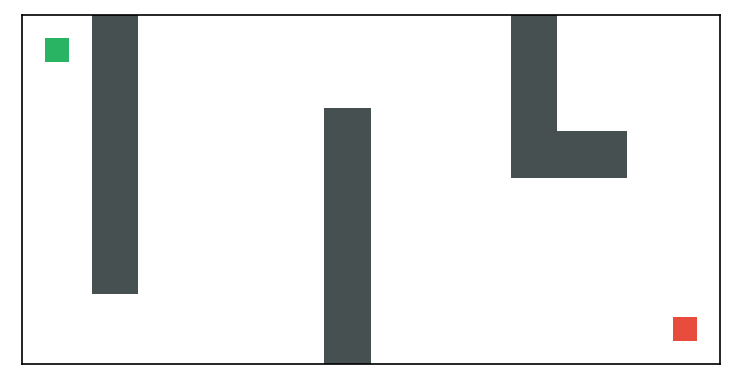

In [8]:
draw_test_map()

Сначала запустим на ней Дийкстру. Для этого нужно передать нулевую эвристику:

Path not found!


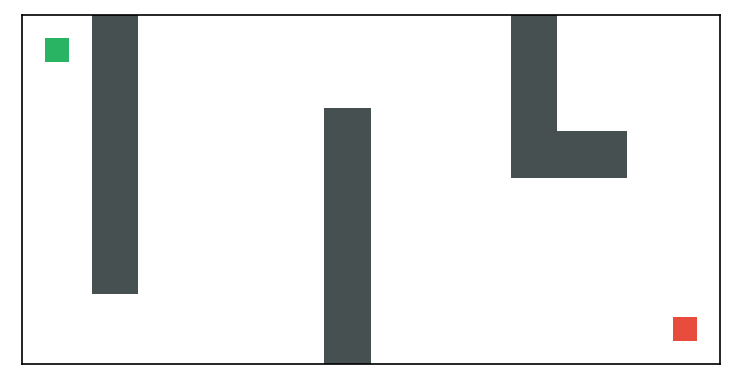

In [9]:
from src.test.simple_test import simple_test
simple_test(a_star, Open, Closed, Grid, (lambda x1, y1, x2, y2: 0))

Теперь запустим A*:

Path not found!


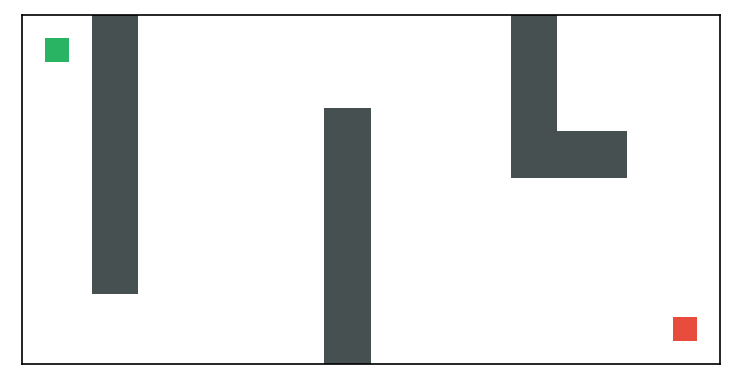

In [10]:
from src.test.simple_test import simple_test
simple_test(a_star, Open, Closed, Grid, manhattan_metric)

Тест завершился успешно, если было напечатано "Path found!" и "Correct: True".

Как видно из результатов, A* рассмотрел ощутимо меньшее число вершин, а значит использовал меньше памяти закончил работу за меньшее время!

### Игра

Теперь вы можете запустить игру. Ваша цель - обозначить начальную и конечную клекти, а также нарисовать препятствия. После запуска робот будет искать кратчайший путь с помощью написанного вами алгоритма.

Управление:
* [Left Click] - закрасить клетку. 
* * Оранжевая клетка - стартовая позиция.
* * Голубая клетка - конечная позиция.
* * Черная клетка - стена (через стены проходить нельзя)
* [Right Click] - стереть клетку.
* [Space] - запустить A* из стартовой клетки в конечную.
* [R] - очистить поле

In [11]:
from src.game_common.game import start_game as start_game_common

In [12]:
start_game_common(a_star, Open, Closed, manhattan_metric)

### Игра++

Хотите чего-то более интересное и более приближенное к реальной жизни?     
Что делать, если у робота будет ограниченая область видимости?    

Управление:
* [Left Click] - закрасить клетку. 
* * Оранжевая клетка - стартовая позиция.
* * Фиолетовая клетка - конечная позиция.
* * Черная клетка - стена (через стены проходить нельзя)
* [Right Click] - стереть клетку.
* [Space] - запустить A* из стартовой клетки в конечную.
* [R] - очистить поле

Параметр [vision] - радиус обзора робота

In [ ]:
from src.game_advanced.game import start_game as start_game_advanced

In [ ]:
start_game_advanced(a_star, Open, Closed, manhattan_metric, vision=5)